In [1]:
import nltk
import re

import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns
import gensim

from nltk.corpus import stopwords
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score, precision_score, recall_score

<div class="alert alert-block alert-danger">
<b>Gensim</b> is a Python library for topic modelling, document indexing and similarity retrieval with large corpora. Target audience is the natural language processing (NLP) and information retrieval (IR) community <br><br>
    <b>https://pypi.org/project/gensim/ </b>
</div>

In [2]:
print("Genism Version: ", gensim.__version__)

Genism Version:  4.3.2


In [3]:
sns.set_context('talk')

In [4]:
nltk.download('stopwords')
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [5]:
def add_movie_descriptor(data: pd.DataFrame, corpus_df: pd.DataFrame):
    """
    Adds "Movie Description" to the supplied dataframe, in the form {Genre}_{P|N}_{Movie Title}_{DocID}
    """
    review = np.where(corpus_df['Review Type (pos or neg)'] == 'Positive', 'P', 'N')
    data['Descriptor'] = corpus_df['Genre of Movie'] + '_' + corpus_df['Movie Title'] + '_' + review + '_' + corpus_df['Doc_ID'].astype(str)

def get_corpus_df(path):
    data = pd.read_csv(path, encoding="utf-8")
    add_movie_descriptor(data, data)
    sorted_data = data.sort_values(['Descriptor'])
    indexed_data = sorted_data.set_index(['Doc_ID'])
    indexed_data['Doc_ID'] = indexed_data.index
    return indexed_data


# Data

In [15]:
CORPUS_PATH=\
'https://raw.githubusercontent.com/barrycforever/MSDS_453_Public/main/MSDS453_ClassCorpus/MSDS453_ClassCorpus_Final_Sec57_v2_20230928.csv'
class_corpus = get_corpus_df(CORPUS_PATH)

In [16]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 9 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
dtypes: int64(1), object(8)
memory usage: 15.6+ KB


# Preprocessing

In [17]:
STOP_WORDS = set(nltk.corpus.stopwords.words('english'))

In [18]:
def remove_punctuation(text):
    return re.sub('[^a-zA-Z]', ' ', str(text))

def lower_case(text):
    return text.lower()

def remove_tags(text):
    return re.sub("&lt;/?.*?&gt;"," &lt;&gt; ", text)

def remove_special_chars_and_digits(text):
    return re.sub("(\\d|\\W)+"," ", text)

def remove_stop_words(tokenized_text):
    custom_stop_words = ['movies', 'movie', 'film', 'films', 'scene']
    STOP_WORDS.update(custom_stop_words)
    return [w for w in tokenized_text if not w in STOP_WORDS]

In [19]:
def normalize(input_text):
    '''
    Normalization involves the following steps:
    1. Remove punctuation
    2. Lower case all words
    3. Remove tags (i.e., HTML tags)
    4. Remove all special characters and digits
    '''
    text = remove_punctuation(input_text)
    text = lower_case(text)
    text = remove_tags(text)
    text = remove_special_chars_and_digits(text)

    return text

In [20]:
def tokenize(text):
    '''
    Tokenization involves the following steps:
    1. Break text down to tokens (i.e., words separated by white spaces)
    2. Remove stop words from the tokens generated in step 1
    '''
    tokens = nltk.word_tokenize(text)
    tokenized_text = remove_stop_words(tokens)

    return tokenized_text

In [21]:
def lemmatize(tokenized_text, lemmatizer=WordNetLemmatizer()):
    '''
    Lemmatization is applied to each word in the list of normalized tokens
    (stop words are removed)
    '''
    return [lemmatizer.lemmatize(word) for word in tokenized_text]

In [22]:
def join_tokens(lemmatized_tokens):
    return ' '.join(lemmatized_tokens)

In [23]:
def get_multi_classification_performance_metrics(X_test, y_test, model, model_name):
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)[::-1]
  plt.figure(figsize=(8,6), dpi=100)
  # Scale up the size of all text
  sns.set(font_scale = 1.1)

  # Plot Confusion Matrix using Seaborn heatmap()
  # Parameters:
  # first param - confusion matrix in array format
  # annot = True: show the numbers in each heatmap cell
  # fmt = 'd': show numbers as integers.
  ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")

  # set x-axis label and ticks.
  ax.set_xlabel("Predicted Genre", fontsize=14, labelpad=20)
  ax.xaxis.set_ticklabels(['Action', 'Comedy', 'Horror', 'Sci-Fi'])

  # set y-axis label and ticks
  ax.set_ylabel("Actual Genre", fontsize=14, labelpad=20)
  ax.yaxis.set_ticklabels(['Action', 'Comedy', 'Horror', 'Sci-Fi'][::-1])

  # set plot title
  ax.set_title(f"Confusion Matrix for {model_name}", fontsize=12, pad=20)

  plt.show()
  print('\n')
  print(classification_report(y_test, y_pred))
  print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
  print(f"Test F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
  print(f"Test Precision: {precision_score(y_test, y_pred, average='weighted')}")
  print(f"Test Recall: {recall_score(y_test, y_pred, average='weighted')}")


def get_binary_classification_performance_metrics(X_test, y_test, model, model_name):
  y_pred = model.predict(X_test)
  cm = confusion_matrix(y_test, y_pred)[::-1]
  plt.figure(figsize=(8,6), dpi=100)
  # Scale up the size of all text
  sns.set(font_scale = 1.1)

  # Plot Confusion Matrix using Seaborn heatmap()
  # Parameters:
  # first param - confusion matrix in array format
  # annot = True: show the numbers in each heatmap cell
  # fmt = 'd': show numbers as integers.
  ax = sns.heatmap(cm, annot=True, fmt='d', cmap="Blues")

  # set x-axis label and ticks.
  ax.set_xlabel("Predicted Genre", fontsize=14, labelpad=20)
  ax.xaxis.set_ticklabels(['Negative', 'Positive'])

  # set y-axis label and ticks
  ax.set_ylabel("Actual Genre", fontsize=14, labelpad=20)
  ax.yaxis.set_ticklabels(['Negative', 'Positive'][::-1])

  # set plot title
  ax.set_title(f"Confusion Matrix for {model_name}", fontsize=14, pad=20)

  plt.show()
  print('\n')
  print(classification_report(y_test, y_pred))
  print(f"Test Accuracy: {accuracy_score(y_test, y_pred)}")
  print(f"Test F1 Score: {f1_score(y_test, y_pred, average='weighted')}")
  print(f"Test Precision: {precision_score(y_test, y_pred, average='weighted')}")
  print(f"Test Recall: {recall_score(y_test, y_pred, average='weighted')}")

In [24]:

class_corpus['normalized_review'] = class_corpus['Text'].apply(normalize)
class_corpus['tokenized_review'] = class_corpus['normalized_review'].apply(tokenize)
class_corpus['lemmatized_tokens'] = class_corpus['tokenized_review'].apply(lemmatize)
class_corpus['lemmatized_text'] = class_corpus['lemmatized_tokens'].apply(join_tokens)

In [25]:
class_corpus.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 200 entries, 90 to 164
Data columns (total 13 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   DSI_Title                 200 non-null    object
 1   Text                      200 non-null    object
 2   Submission File Name      200 non-null    object
 3   Student Name              200 non-null    object
 4   Genre of Movie            200 non-null    object
 5   Review Type (pos or neg)  200 non-null    object
 6   Movie Title               200 non-null    object
 7   Descriptor                200 non-null    object
 8   Doc_ID                    200 non-null    int64 
 9   normalized_review         200 non-null    object
 10  tokenized_review          200 non-null    object
 11  lemmatized_tokens         200 non-null    object
 12  lemmatized_text           200 non-null    object
dtypes: int64(1), object(12)
memory usage: 21.9+ KB


# Feature Extraction

## Doc2Vec

In [26]:
documents = [TaggedDocument(doc, [i]) for i, doc in enumerate(class_corpus.lemmatized_tokens)]

In [27]:
model_doc2vec = Doc2Vec(documents,
                        vector_size=1000,
                        min_count=1,
                        workers=4)

In [28]:
features_doc2vec = pd.DataFrame()

for document in documents:
    vector = pd.DataFrame(model_doc2vec.infer_vector(document.words)).transpose()
    features_doc2vec = pd.concat([features_doc2vec, vector])

In [29]:
features_doc2vec.shape

(200, 1000)

# Sentiment Analysis

In [30]:
labels = class_corpus['Review Type (pos or neg)']

In [31]:
labels.value_counts()

Negative    100
Positive    100
Name: Review Type (pos or neg), dtype: int64

In [32]:
X_train, X_test, y_train, y_test = train_test_split(features_doc2vec, labels,
                                                    test_size=0.33,
                                                    random_state=20130810)

## Support Vector Machine

As an example, let us train a [support vector machine](https://scikit-learn.org/stable/modules/svm.html) with the default settings.

The best paramaters should of course be estimated through a hyperparameter tuning loop.

In [34]:
for C_value in [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]:

    model_svm = SVC(C=C_value, random_state=10)
    model_svm.fit(X_train, y_train)
    y_pred = model_svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"C: {C_value}, Accuracy: {acc}")

C: 0.01, Accuracy: 0.5151515151515151
C: 0.1, Accuracy: 0.5151515151515151
C: 1, Accuracy: 0.5151515151515151
C: 10, Accuracy: 0.4696969696969697
C: 100, Accuracy: 0.48484848484848486
C: 1000, Accuracy: 0.5151515151515151
C: 10000, Accuracy: 0.5303030303030303
C: 100000, Accuracy: 0.45454545454545453


The best accuracy is when `C = 10000`.


In [35]:
model_svm = SVC(C=10000, random_state=10)
model_svm.fit(X_train, y_train)

SVC(C=10000, random_state=10)

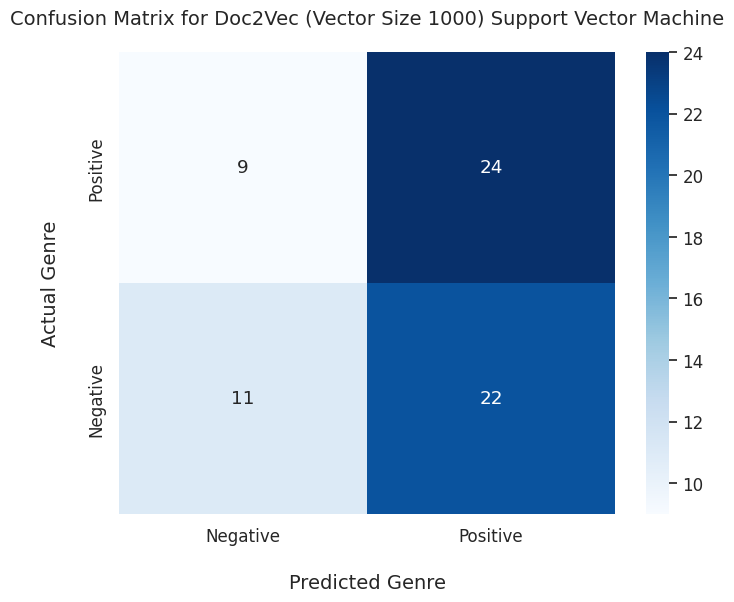



              precision    recall  f1-score   support

    Negative       0.55      0.33      0.42        33
    Positive       0.52      0.73      0.61        33

    accuracy                           0.53        66
   macro avg       0.54      0.53      0.51        66
weighted avg       0.54      0.53      0.51        66

Test Accuracy: 0.5303030303030303
Test F1 Score: 0.5113446381657512
Test Precision: 0.5358695652173913
Test Recall: 0.5303030303030303


In [36]:
get_binary_classification_performance_metrics(X_test, y_test, model_svm, 'Doc2Vec (Vector Size 1000) Support Vector Machine')

## Decision Tree

In [37]:
for max_depth in range(1,100,1):
  model_dtc = DTC(max_depth=max_depth, random_state=10)
  model_dtc.fit(X_train, y_train)
  y_pred = model_dtc.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"max_depth: {max_depth}\tAccuracy: {acc}")

max_depth: 1	Accuracy: 0.4393939393939394
max_depth: 2	Accuracy: 0.45454545454545453
max_depth: 3	Accuracy: 0.42424242424242425
max_depth: 4	Accuracy: 0.45454545454545453
max_depth: 5	Accuracy: 0.5
max_depth: 6	Accuracy: 0.5
max_depth: 7	Accuracy: 0.4696969696969697
max_depth: 8	Accuracy: 0.45454545454545453
max_depth: 9	Accuracy: 0.4696969696969697
max_depth: 10	Accuracy: 0.4696969696969697
max_depth: 11	Accuracy: 0.4696969696969697
max_depth: 12	Accuracy: 0.4696969696969697
max_depth: 13	Accuracy: 0.4696969696969697
max_depth: 14	Accuracy: 0.4696969696969697
max_depth: 15	Accuracy: 0.4696969696969697
max_depth: 16	Accuracy: 0.4696969696969697
max_depth: 17	Accuracy: 0.4696969696969697
max_depth: 18	Accuracy: 0.4696969696969697
max_depth: 19	Accuracy: 0.4696969696969697
max_depth: 20	Accuracy: 0.4696969696969697
max_depth: 21	Accuracy: 0.4696969696969697
max_depth: 22	Accuracy: 0.4696969696969697
max_depth: 23	Accuracy: 0.4696969696969697
max_depth: 24	Accuracy: 0.4696969696969697
max

In [38]:
model_dtc = DTC(max_depth=5, random_state=10)
model_dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, random_state=10)

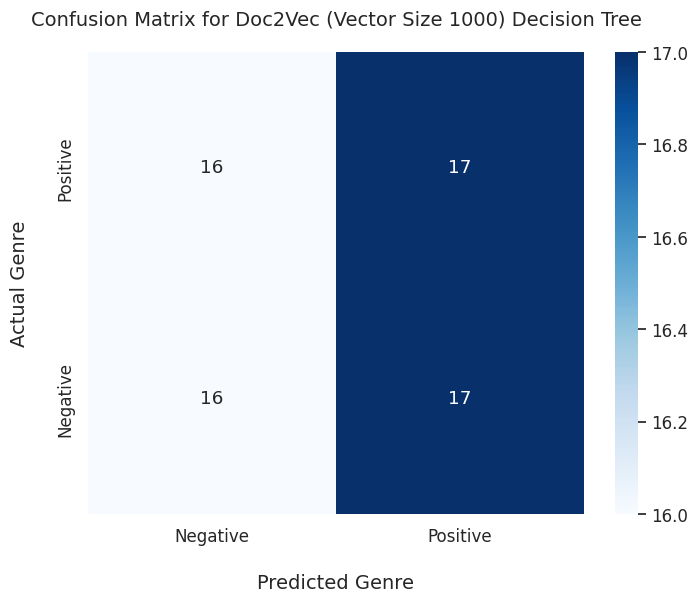



              precision    recall  f1-score   support

    Negative       0.50      0.48      0.49        33
    Positive       0.50      0.52      0.51        33

    accuracy                           0.50        66
   macro avg       0.50      0.50      0.50        66
weighted avg       0.50      0.50      0.50        66

Test Accuracy: 0.5
Test F1 Score: 0.4998851894374282
Test Precision: 0.5
Test Recall: 0.5


In [39]:
get_binary_classification_performance_metrics(X_test, y_test, model_dtc, 'Doc2Vec (Vector Size 1000) Decision Tree')

# Random Forest

In [40]:
for n_estimator in range(10, 301, 10):
  model_rf = RFC(n_estimators=n_estimator, random_state=10)
  model_rf.fit(X_train, y_train)
  y_pred = model_rf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"n_estimator: {n_estimator}\tAccuracy: {acc}")

n_estimator: 10	Accuracy: 0.5606060606060606
n_estimator: 20	Accuracy: 0.5757575757575758
n_estimator: 30	Accuracy: 0.5757575757575758
n_estimator: 40	Accuracy: 0.5606060606060606
n_estimator: 50	Accuracy: 0.6060606060606061
n_estimator: 60	Accuracy: 0.5606060606060606
n_estimator: 70	Accuracy: 0.5454545454545454
n_estimator: 80	Accuracy: 0.5151515151515151
n_estimator: 90	Accuracy: 0.5151515151515151
n_estimator: 100	Accuracy: 0.5303030303030303
n_estimator: 110	Accuracy: 0.5
n_estimator: 120	Accuracy: 0.48484848484848486
n_estimator: 130	Accuracy: 0.48484848484848486
n_estimator: 140	Accuracy: 0.5303030303030303
n_estimator: 150	Accuracy: 0.5
n_estimator: 160	Accuracy: 0.5454545454545454
n_estimator: 170	Accuracy: 0.5454545454545454
n_estimator: 180	Accuracy: 0.5454545454545454
n_estimator: 190	Accuracy: 0.5151515151515151
n_estimator: 200	Accuracy: 0.5
n_estimator: 210	Accuracy: 0.5151515151515151
n_estimator: 220	Accuracy: 0.5151515151515151
n_estimator: 230	Accuracy: 0.5
n_estimat

In [41]:
model_rf = RFC(n_estimators=20, random_state=10)
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=20, random_state=10)

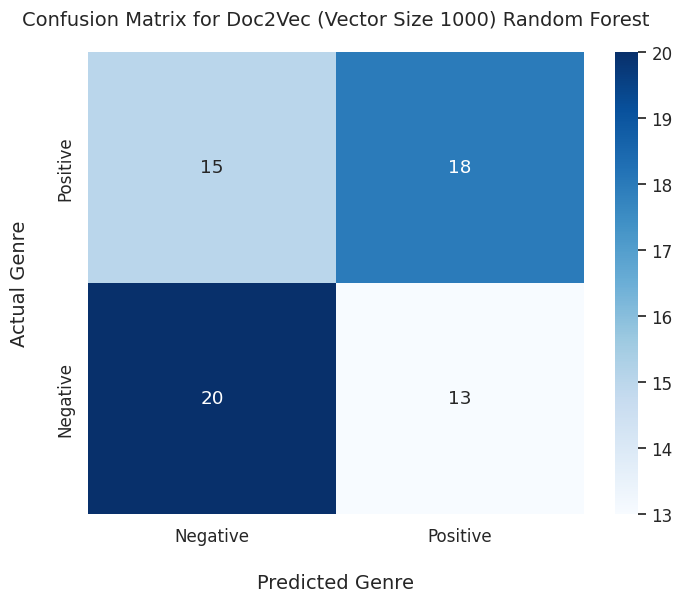



              precision    recall  f1-score   support

    Negative       0.57      0.61      0.59        33
    Positive       0.58      0.55      0.56        33

    accuracy                           0.58        66
   macro avg       0.58      0.58      0.58        66
weighted avg       0.58      0.58      0.58        66

Test Accuracy: 0.5757575757575758
Test F1 Score: 0.5753676470588235
Test Precision: 0.576036866359447
Test Recall: 0.5757575757575758


In [42]:
get_binary_classification_performance_metrics(X_test, y_test, model_rf, 'Doc2Vec (Vector Size 1000) Random Forest')

# Multi-class Classification

In [43]:
labels = class_corpus['Genre of Movie']

In [44]:
labels.value_counts()

Action    50
Comedy    50
Horror    50
Sci-Fi    50
Name: Genre of Movie, dtype: int64

In [45]:
X_train, X_test, y_train, y_test = train_test_split(features_doc2vec, labels,
                                                    test_size=0.33,
                                                    stratify=labels,
                                                    random_state=20130810)

In [46]:
y_test.value_counts()

Horror    17
Action    17
Comedy    16
Sci-Fi    16
Name: Genre of Movie, dtype: int64

## Support Vector Machine

In [48]:
for C_value in [0.01, 0.1, 1, 10, 100, 1000, 10000, 100000]:
    model_svm = SVC(C=C_value, random_state=10)
    model_svm.fit(X_train, y_train)
    y_pred = model_svm.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    print(f"C: {C_value}, Accuracy: {acc}")

C: 0.01, Accuracy: 0.21212121212121213
C: 0.1, Accuracy: 0.21212121212121213
C: 1, Accuracy: 0.19696969696969696
C: 10, Accuracy: 0.24242424242424243
C: 100, Accuracy: 0.25757575757575757
C: 1000, Accuracy: 0.3333333333333333
C: 10000, Accuracy: 0.7272727272727273
C: 100000, Accuracy: 0.9848484848484849


In [49]:
model_svm = SVC(C=100000, random_state=10)
model_svm.fit(X_train, y_train)

SVC(C=100000, random_state=10)

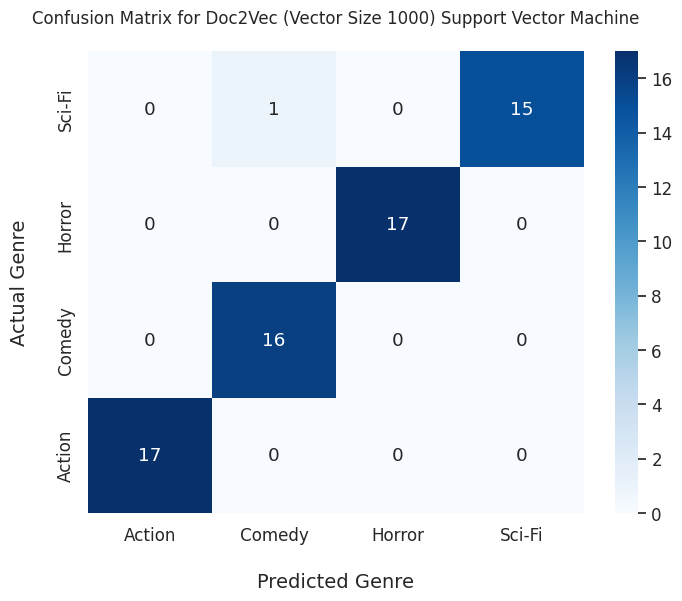



              precision    recall  f1-score   support

      Action       1.00      1.00      1.00        17
      Comedy       0.94      1.00      0.97        16
      Horror       1.00      1.00      1.00        17
      Sci-Fi       1.00      0.94      0.97        16

    accuracy                           0.98        66
   macro avg       0.99      0.98      0.98        66
weighted avg       0.99      0.98      0.98        66

Test Accuracy: 0.9848484848484849
Test F1 Score: 0.9848336739832341
Test Precision: 0.9857397504456329
Test Recall: 0.9848484848484849


In [50]:
get_multi_classification_performance_metrics(X_test, y_test, model_svm, 'Doc2Vec (Vector Size 1000) Support Vector Machine')

## Decision Tree

In [51]:
for max_depth in range(1,1000,50):
  model_dtc = DTC(max_depth=max_depth, random_state=10)
  model_dtc.fit(X_train, y_train)
  y_pred = model_dtc.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"max_depth: {max_depth}\tAccuracy: {acc}")

max_depth: 1	Accuracy: 0.2727272727272727
max_depth: 51	Accuracy: 0.36363636363636365
max_depth: 101	Accuracy: 0.36363636363636365
max_depth: 151	Accuracy: 0.36363636363636365
max_depth: 201	Accuracy: 0.36363636363636365
max_depth: 251	Accuracy: 0.36363636363636365
max_depth: 301	Accuracy: 0.36363636363636365
max_depth: 351	Accuracy: 0.36363636363636365
max_depth: 401	Accuracy: 0.36363636363636365
max_depth: 451	Accuracy: 0.36363636363636365
max_depth: 501	Accuracy: 0.36363636363636365
max_depth: 551	Accuracy: 0.36363636363636365
max_depth: 601	Accuracy: 0.36363636363636365
max_depth: 651	Accuracy: 0.36363636363636365
max_depth: 701	Accuracy: 0.36363636363636365
max_depth: 751	Accuracy: 0.36363636363636365
max_depth: 801	Accuracy: 0.36363636363636365
max_depth: 851	Accuracy: 0.36363636363636365
max_depth: 901	Accuracy: 0.36363636363636365
max_depth: 951	Accuracy: 0.36363636363636365


In [52]:
model_dtc = DTC(max_depth=50, random_state=10)
model_dtc.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=50, random_state=10)

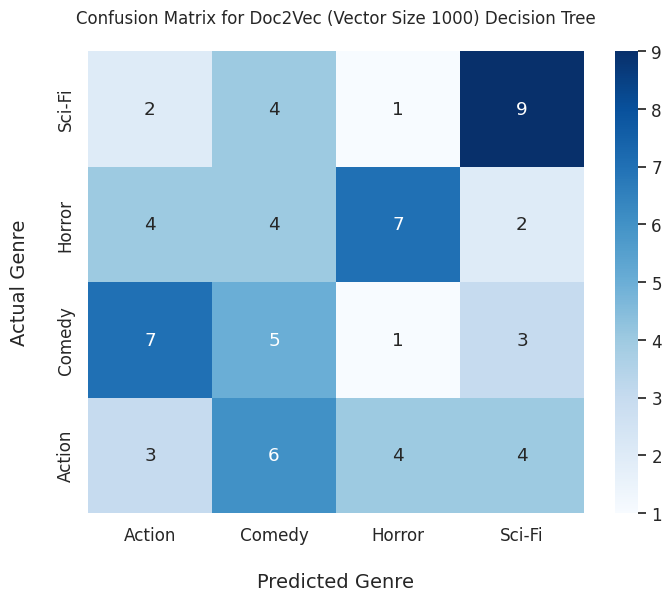



              precision    recall  f1-score   support

      Action       0.19      0.18      0.18        17
      Comedy       0.26      0.31      0.29        16
      Horror       0.54      0.41      0.47        17
      Sci-Fi       0.50      0.56      0.53        16

    accuracy                           0.36        66
   macro avg       0.37      0.37      0.37        66
weighted avg       0.37      0.36      0.36        66

Test Accuracy: 0.36363636363636365
Test F1 Score: 0.36464029137825926
Test Precision: 0.3719980677217519
Test Recall: 0.36363636363636365


In [53]:
get_multi_classification_performance_metrics(X_test, y_test, model_dtc, 'Doc2Vec (Vector Size 1000) Decision Tree')

## Random Forest

In [54]:
for n_estimator in range(1, 1000, 50):
  model_rf = RFC(n_estimators=n_estimator, random_state=10)
  model_rf.fit(X_train, y_train)
  y_pred = model_rf.predict(X_test)
  acc = accuracy_score(y_test, y_pred)
  print(f"n_estimator: {n_estimator}\tAccuracy: {acc}")

n_estimator: 1	Accuracy: 0.3787878787878788
n_estimator: 51	Accuracy: 0.5757575757575758
n_estimator: 101	Accuracy: 0.5909090909090909
n_estimator: 151	Accuracy: 0.5757575757575758
n_estimator: 201	Accuracy: 0.5909090909090909
n_estimator: 251	Accuracy: 0.6212121212121212
n_estimator: 301	Accuracy: 0.6060606060606061
n_estimator: 351	Accuracy: 0.6060606060606061
n_estimator: 401	Accuracy: 0.5909090909090909
n_estimator: 451	Accuracy: 0.5909090909090909
n_estimator: 501	Accuracy: 0.5909090909090909
n_estimator: 551	Accuracy: 0.6060606060606061
n_estimator: 601	Accuracy: 0.6212121212121212
n_estimator: 651	Accuracy: 0.6212121212121212
n_estimator: 701	Accuracy: 0.6212121212121212
n_estimator: 751	Accuracy: 0.6363636363636364
n_estimator: 801	Accuracy: 0.6363636363636364
n_estimator: 851	Accuracy: 0.6212121212121212
n_estimator: 901	Accuracy: 0.6363636363636364
n_estimator: 951	Accuracy: 0.6363636363636364


In [55]:
model_rf = RFC(n_estimators=750, random_state=10)
model_rf.fit(X_train, y_train)

RandomForestClassifier(n_estimators=750, random_state=10)

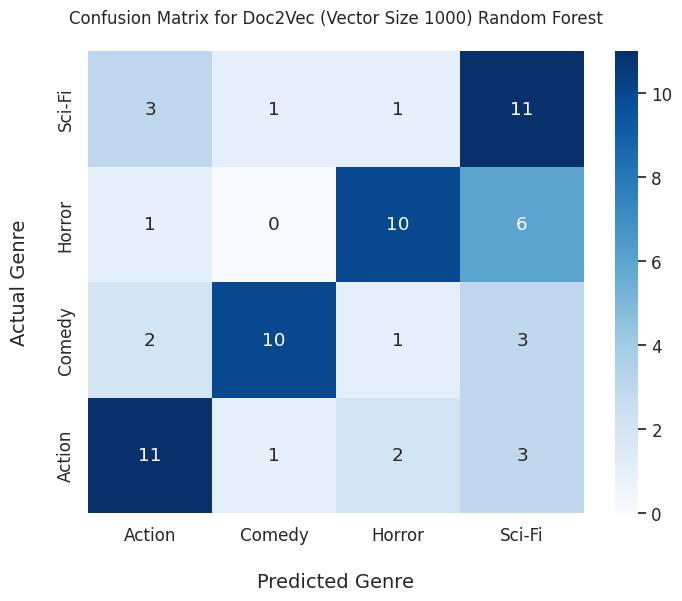



              precision    recall  f1-score   support

      Action       0.65      0.65      0.65        17
      Comedy       0.83      0.62      0.71        16
      Horror       0.71      0.59      0.65        17
      Sci-Fi       0.48      0.69      0.56        16

    accuracy                           0.64        66
   macro avg       0.67      0.64      0.64        66
weighted avg       0.67      0.64      0.64        66

Test Accuracy: 0.6363636363636364
Test F1 Score: 0.6427568846923687
Test Precision: 0.66861158165506
Test Recall: 0.6363636363636364


In [56]:
get_multi_classification_performance_metrics(X_test, y_test, model_rf, 'Doc2Vec (Vector Size 1000) Random Forest')

# Conclusion

When text is an input to a supervised learning task (e.g., sentiment analysis or multi-class prediction) detailed examination of the classification metrics helps select the appropriate feature engineering process.